# Figure 1.f/g : Training efficiency

Goals : 

- Show that 3D models are more efficient in terms of training data needed to reach a certain accuracy, compared to 2D models.
  
(Also shows slight advantage of 3D models in terms of accuracy, and performance of self-supervised model.)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from tifffile import imread
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sys.path.append("../..")

from utils import *
from plots import *

show_params()

Plot parameters (set in plots.py) : 
- COLORMAP : ████████
- DPI : 200
- Data path : C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK
- Font size : 20
- Title font size : 25.0
- Label font size : 20.0


In [3]:
SAVE_PLOTS_AS_PNG = False
SAVE_PLOTS_AS_SVG = True

## Data loading

In [4]:
image_folder = DATA_PATH / "RESULTS/SPLITS/Analysis"
c5 = imread(image_folder / "c5.tif")
c3 = imread(image_folder / "c3.tif")
visual = imread(image_folder / "visual.tif")

# Visual contains artifact in the 0:50 slice
# This is unused now, this should always be run with artifacts. See below for WNet3D evaluation details
EVALUATE_ON_ARTIFACTS = True

if not EVALUATE_ON_ARTIFACTS:
    visual_slice = 50
else:
    visual_slice = -1

gt_dict = {
    "visual": visual[:visual_slice,:,:],
    "c3": c3,
    "c5": c5,
}

### Order data by model and split

In [5]:
visual_preds = {
    "cellpose": {
        "8020": image_folder / "c1_5/cp/iso_visual_c1-5_visual_8020.tif",
        # "8020": image_folder / "c1_5/cp_radius5/iso_visual_c1-5_visual_8020.tif",
        "6040": image_folder / "c1_5/cp/iso_visual_c1-5_visual_6040.tif",
        # "6040": image_folder / "c1_5/cp_radius5/iso_visual_c1-5_visual_6040.tif"
        "2080": image_folder / "c1_5/cp/iso_visual_c1-5_visual_2080.tif"
    },
    "stardist": {
        "8020": image_folder / "c1_5/sd/stardist_8020_labels.tif",
        "6040": image_folder / "c1_5/sd/stardist_6040_labels.tif",
        "2080": image_folder / "c1_5/sd/stardist_2080_labels.tif"
    },
    "segres": {
        "8020": image_folder / "c1_5/segres/c1_5_8020_SegRes.tif",
        "6040": image_folder / "c1_5/segres/c1_5_6040_SegRes.tif",
        "2080": image_folder / "c1_5/segres/c1_5_2080_SegRes.tif"
        
    },
    "swin": {
        "8020": image_folder / "c1_5/swin/c1-5_8020_Swin.tif",
        "6040": image_folder / "c1_5/swin/c1-5_6040_Swin.tif",
        "2080": image_folder / "c1_5/swin/c1-5_2080_Swin.tif",
    },
}
c3_preds = {
    "cellpose": {
        "8020": image_folder / "c1245_v/cp/c3image_c1245_v_8020.tif",
        "6040": image_folder / "c1245_v/cp/c3image_c1245_v_6040.tif",
        "2080": image_folder / "c1245_v/cp/c3image_c1245_v_2080.tif"
    },
    "stardist": {
        "8020": image_folder / "c1245_v/sd/stardist_8020_labels.tif",
        "6040": image_folder / "c1245_v/sd/stardist_6040_labels.tif",
        "2080": image_folder / "c1245_v/sd/stardist_2080_labels.tif"
    },
    "segres": {
        "8020": image_folder / "c1245_v/segres/c1245-v_8020_SegRes.tif",
        "6040": image_folder / "c1245_v/segres/c1245-v_6040_SegRes.tif",
        "2080": image_folder / "c1245_v/segres/c1245-v_2080_SegRes.tif"
    },
    "swin": {
        "8020": image_folder / "c1245_v/swin/c1245-v_8020_Swin.tif",
        "6040": image_folder / "c1245_v/swin/c1245-v_6040_Swin.tif",
        "2080": image_folder / "c1245_v/swin/c1245-v_2080_Swin.tif"
    },
}
c5_preds = {
    "cellpose": {
        "8020": image_folder / "c1-4_v/cp/c5image_c1-4_v_8020.tif",
        "6040": image_folder / "c1-4_v/cp/c5image_c1-4_v_6040.tif",
        "2080": image_folder / "c1-4_v/cp/c5image_c1-4_v_2080.tif"
    },
    "stardist": {
        "8020": image_folder / "c1-4_v/sd/stardist_8020_labels.tif",
        "6040": image_folder / "c1-4_v/sd/stardist_6040_labels.tif",
        "2080": image_folder / "c1-4_v/sd/stardist_2080_labels.tif"
    },
    "segres": {
        "8020": image_folder / "c1-4_v/segres/c1-4-v_8020_SegRes.tif",
        "6040": image_folder / "c1-4_v/segres/c1-4-v_6040_SegRes.tif",
        "2080": image_folder / "c1-4_v/segres/c1-4-v_2080_SegRes.tif"
    },
    "swin": {
        "8020": image_folder / "c1-4_v/swin/c1-4-v_8020_Swin.tif",
        "6040": image_folder / "c1-4_v/swin/c1-4-v_6040_Swin.tif",
        "2080": image_folder / "c1-4_v/swin/c1-4-v_2080_Swin.tif"
    },
}

In [6]:
cellpose_preds = {
    "2080": {
        "visual": imread(visual_preds["cellpose"]["2080"])[:visual_slice,:,:],
        "c3": imread(c3_preds["cellpose"]["2080"]),
        "c5": imread(c5_preds["cellpose"]["2080"]),
    },
    "6040": {
        "visual": imread(visual_preds["cellpose"]["6040"])[:visual_slice,:,:],
        "c3": imread(c3_preds["cellpose"]["6040"]),
        "c5": imread(c5_preds["cellpose"]["6040"]),
    },
    "8020": {
        "visual": imread(visual_preds["cellpose"]["8020"])[:visual_slice,:,:],
        "c3": imread(c3_preds["cellpose"]["8020"]),
        "c5": imread(c5_preds["cellpose"]["8020"]),
    },
}
stardist_preds = {
    "2080": {
        "visual": imread(visual_preds["stardist"]["2080"])[:visual_slice,:,:],
        "c3": imread(c3_preds["stardist"]["2080"]),
        "c5": imread(c5_preds["stardist"]["2080"]),
    },
    "6040": {
        "visual": imread(visual_preds["stardist"]["6040"])[:visual_slice,:,:],
        "c3": imread(c3_preds["stardist"]["6040"]),
        "c5": imread(c5_preds["stardist"]["6040"]),
    },
    "8020": {
        "visual": imread(visual_preds["stardist"]["8020"])[:visual_slice,:,:],
        "c3": imread(c3_preds["stardist"]["8020"]),
        "c5": imread(c5_preds["stardist"]["8020"]),
    },
}
segres_preds = {
    "2080": {
        "visual": imread(visual_preds["segres"]["2080"])[:visual_slice,:,:],
        "c3": imread(c3_preds["segres"]["2080"]),
        "c5": imread(c5_preds["segres"]["2080"]),
    },
    "6040": {
        "visual": imread(visual_preds["segres"]["6040"])[:visual_slice,:,:],
        "c3": imread(c3_preds["segres"]["6040"]),
        "c5": imread(c5_preds["segres"]["6040"]),
    },
    "8020": {
        "visual": imread(visual_preds["segres"]["8020"])[:visual_slice,:,:],
        "c3": imread(c3_preds["segres"]["8020"]),
        "c5": imread(c5_preds["segres"]["8020"]),
    },
}
swin_preds = {
    "2080": {
        "visual": imread(visual_preds["swin"]["2080"])[:visual_slice,:,:],
        "c3": imread(c3_preds["swin"]["2080"]),
        "c5": imread(c5_preds["swin"]["2080"]),
    },
    "6040": {
        "visual": imread(visual_preds["swin"]["6040"])[:visual_slice,:,:],
        "c3": imread(c3_preds["swin"]["6040"]),
        "c5": imread(c5_preds["swin"]["6040"]),
    },
    "8020": {
        "visual": imread(visual_preds["swin"]["8020"])[:visual_slice,:,:],
        "c3": imread(c3_preds["swin"]["8020"]),
        "c5": imread(c5_preds["swin"]["8020"]),
    },
}
wnet_visual_pred = imread(image_folder / "WNet/visual_pred.tif")[:visual_slice,:,:]
wnet_c3_pred = imread(image_folder / "WNet/c3_pred.tif")
wnet_c5_pred = imread(image_folder / "WNet/c5_pred.tif")

wnet_preds = {
    "2080": { # just a dummy, as only one model was trained (on all images, self-supervised)
        "visual": wnet_visual_pred,
        "c3": wnet_c3_pred,
        "c5": wnet_c5_pred,
    },
}


```{note}
For WNet3D, we compute two sets of Dices :

- One on c3, c5 and ALL of visual, which contains some artifacts. This is "All data".
- One on c3, c5 and PART of visual, which does not contain artifacts. This is "No artifacts".

In [7]:
visual_slice = 50
visual_gt_no_artifact = gt_dict["visual"][:visual_slice,:,:]
wnet_visual_no_artifact = wnet_visual_pred[:visual_slice,:,:]

## Dice computation

In [8]:
def model_dices_across_splits(model_dict, verbose=False):
    model_dices = {
        "2080": [],
        "6040": [],
        "8020": [],
    }
    for split in model_dict:
        for image in model_dict[split]:
            gt = gt_dict[image]
            pred = model_dict[split][image]
            gt = np.where(gt > 0, 1, 0)
            pred = np.where(pred > 0, 1, 0)
            dice = dice_coeff(gt, pred)
            if verbose:
                print(f"Split: {split}, Image: {image}")
                print(f"Image shape: {model_dict[split][image].shape}")
                print(f"GT shape: {gt_dict[image].shape}")
                print(f"Dice: {dice}")
            model_dices[split].append(dice)
    return model_dices

In [9]:
cellpose_dices = model_dices_across_splits(cellpose_preds)

In [10]:
stardist_dices = model_dices_across_splits(stardist_preds)

In [11]:
segres_dices = model_dices_across_splits(segres_preds)

In [12]:
swin_dices = model_dices_across_splits(swin_preds)

In [13]:
wnet_dices = model_dices_across_splits(wnet_preds) # All data

In [14]:
wnet_preds_no_artifacts = { # No artifacts
    "WNet3D - No artifacts": {
        "visual": wnet_visual_no_artifact,
        "c3": wnet_c3_pred,
        "c5": wnet_c5_pred,
    }
}
gt_dict_no_artifacts = {
    "visual": visual_gt_no_artifact,
    "c3": c3,
    "c5": c5,
}
wnet_dices_no_artifacts = []

for split in wnet_preds_no_artifacts:
    for image in wnet_preds_no_artifacts[split]:
        gt = gt_dict_no_artifacts[image]
        pred = wnet_preds_no_artifacts[split][image]
        gt = np.where(gt > 0, 1, 0)
        pred = np.where(pred > 0, 1, 0)
        dice = dice_coeff(gt, pred)
        wnet_dices_no_artifacts.append(dice)

In [15]:
model_names = [
    "Stardist", 
    "Cellpose", 
    "SegResNet", 
    "SwinUNetR", 
    "WNet3D"
    ]
models = [cellpose_dices, stardist_dices, segres_dices, swin_dices]
# wnet_means = [np.mean(wnet_dices["8020"]), np.mean(wnet_dices["6040"]), np.mean(wnet_dices["2080"])]

plt.rcParams["figure.figsize"] = (8, 8)

In [16]:
# creata a dataframe with each model dice, adding the split as a categorical variable
dices_df = pd.DataFrame(columns=["Model", "Dice", "Split"])
dices_df["Model"] = ["Stardist"] * 9 + ["Cellpose"] * 9 + ["SegResNet"] * 9 + ["SwinUNetR"] * 9 + ["WNet3D"] * 3
dices_df["Dice"] = stardist_dices["2080"] + stardist_dices["6040"] + stardist_dices["8020"] + cellpose_dices["2080"] + cellpose_dices["6040"] + cellpose_dices["8020"] + segres_dices["2080"] + segres_dices["6040"] + segres_dices["8020"] + swin_dices["2080"] + swin_dices["6040"] + swin_dices["8020"] + wnet_dices["2080"]
dices_df["Split"] = ["20/80"] * 3 + ["60/40"] * 3 + ["80/20"] * 3 + ["20/80"] * 3 + ["60/40"] * 3 + ["80/20"] * 3 + ["20/80"] * 3 + ["60/40"] * 3 + ["80/20"] * 3 + ["20/80"] * 3 + ["60/40"] * 3 + ["80/20"] * 3 + ["Self-supervised - All data"] * 3

### WNet3D - No artifacts

In [17]:
# add Wnet with a no artifact split
dices_df_no_artifacts = pd.DataFrame(columns=["Model", "Dice", "Split"])
dices_df_no_artifacts["Model"] = ["WNet3D"] * 3
dices_df_no_artifacts["Split"] = ["Self-supervised - No artifacts"] * 3
dices_df_no_artifacts["Dice"] = wnet_dices_no_artifacts

In [18]:
dices_df_no_artifacts

,Model,Dice,Split
0,WNet3D,0.618709,Self-supervised - No artifacts
1,WNet3D,0.811354,Self-supervised - No artifacts
2,WNet3D,0.808755,Self-supervised - No artifacts


In [19]:
dices_df = pd.concat([dices_df, dices_df_no_artifacts])

### All Dice coefficients

In [20]:
dice_df_t = dices_df.groupby(["Model", "Split"]).apply(lambda x: x, include_groups=False)
dice_df_t

Dice
Model     Split                                      
Cellpose  20/80                          9   0.385060
                                         10  0.413332
                                         11  0.434634
          60/40                          12  0.324285
                                         13  0.461056
                                         14  0.287788
          80/20                          15  0.535737
                                         16  0.358649
                                         17  0.421258
SegResNet 20/80                          18  0.683832
                                         19  0.690604
                                         20  0.801169
          60/40                          21  0.695818
                                         22  0.840746
                                         23  0.617691
          80/20                          24  0.673795
                                         25  0.773206
                                         26  0.634920
Stardist  20/80                          0   0.692542
                                         1   0.000017
                                         2   0.000024
          60/40                          3   0.650010
                                         4   0.521939
                                         5   0.725773
          80/20                          6   0.664940
                                         7   0.522854
                                         8   0.630641
SwinUNetR 20/80                          27  0.736177
                                         28  0.835875
                                         29  0.835130
          60/40                          30  0.821806
                                         31  0.848575
                                         32  0.838228
          80/20                          33  0.832200
                                         34  0.839906
                                         35  0.820599
WNet3D    Self-supervised - All data     36  0.618709
                                         37  0.811354
                                         38  0.808755
          Self-supervised - No artifacts 0   0.618709
                                         1   0.811354
                                         2   0.808755

### Detailed stats 
Shows means and stds of select splits for manuscript.

In [21]:
dice_df_8020 = dices_df[dices_df["Split"] == "80/20"]
dice_df_8020.groupby("Model").agg({"Dice": ["mean", "std"]})

Dice          
               mean       std
Model                        
Cellpose   0.438548  0.089801
SegResNet  0.693973  0.071317
Stardist   0.606145  0.074143
SwinUNetR  0.830902  0.009719

In [22]:
dice_df_wnet = dices_df[dices_df["Model"] == "WNet3D"]
dice_df_wnet.groupby("Split").agg({"Dice": ["mean", "std"]})

Dice          
                                    mean       std
Split                                             
Self-supervised - All data      0.746272  0.110481
Self-supervised - No artifacts  0.746272  0.110481

## Plots

In [23]:
dices_df['Model_Split'] = dices_df['Model'] + ' (' + dices_df['Split'].astype(str) + ')'

Due to the way seaborn boxplots interact with categories, the axes will be generated for all models/splits, and then separate boxplots are used to have readable boxes for each model.

The data is the same everywhere, this is only to have cleaner figures.

In addition, since SwinUNetR and WNet have much smaller variance, we show a zoomed-in inset for these models.

### General plot

C:\Users\Cyril\AppData\Local\Temp\ipykernel_26660\2494682398.py:2: UserWarning: The palette list has more values (16) than needed (14), which may not be intended.
  sns.boxplot(


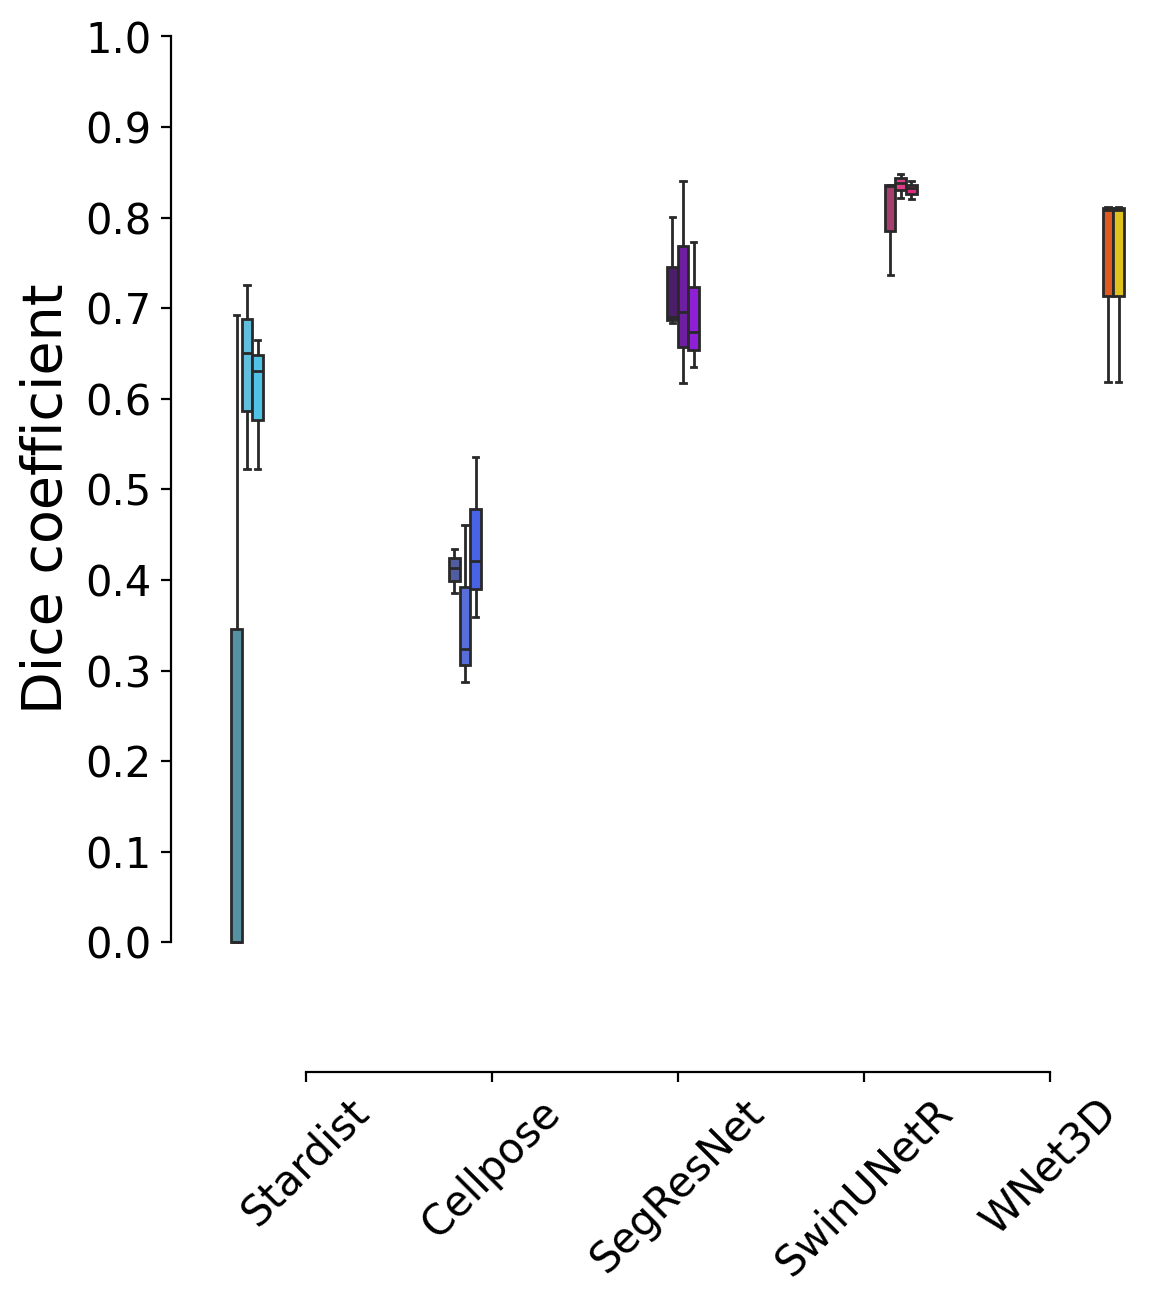

In [24]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=DPI)
sns.boxplot(
    data=dices_df,
    x="Model", 
    y="Dice", 
    hue="Model_Split", 
    ax=ax, 
    palette=EXPANDED_COLORMAP,
    # dodge=False,
    )
for i, artist in enumerate(ax.artists): # try to center the boxplot on xticks
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(artist.get_facecolor())
        if j % 6 == 4: 
            x, y = line.get_xydata()[0]
            x_center = i // 2 
            if i % 2: 
                line.set_xdata([x_center + 0.2, x_center + 0.2, x, x_center + 0.2])
            else:  
                line.set_xdata([x_center - 0.2, x_center - 0.2, x, x_center - 0.2])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(axis="both", which="major", labelsize=LEGEND_FONT_SIZE)
ax.tick_params(axis = 'x',   rotation = 45)
plt.ylim([-0.02,1])
ax.set_yticks(np.arange(0,1.1,0.1))
sns.despine(
    left=False,
    right=True,
    bottom=False,
    top=True,
    trim=True,
    offset={"bottom": 40, "left": 15},
)
legend = ax.legend(fontsize=LEGEND_FONT_SIZE, bbox_to_anchor=BBOX_TO_ANCHOR, loc=LOC)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
legend.get_frame().set_alpha(0)
ax.set_xlabel("", fontsize=LABEL_FONT_SIZE)
ax.set_ylabel("Dice coefficient", fontsize=LABEL_FONT_SIZE)
plt.legend([],[], frameon=False)
plt.show()

if SAVE_PLOTS_AS_PNG:
    fig.savefig("Label_efficiency.png", dpi=DPI, bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    fig.savefig("Label_efficiency.svg", bbox_inches="tight")

### Legend

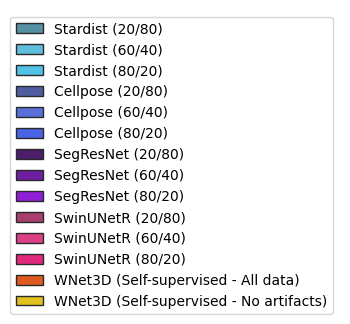

In [25]:
fig_leg = plt.figure(figsize=(3, 2))
ax_leg = fig_leg.add_subplot(111)
ax_leg.legend(handles=legend.legend_handles, labels=[text.get_text() for text in legend.texts])
ax_leg.axis('off')
plt.show()
if SAVE_PLOTS_AS_PNG:
    fig_leg.savefig("Label_efficiency_legend.png", dpi=DPI, bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    fig_leg.savefig("Label_efficiency_legend.svg", bbox_inches="tight")

### Boxplots for each model

Stardist


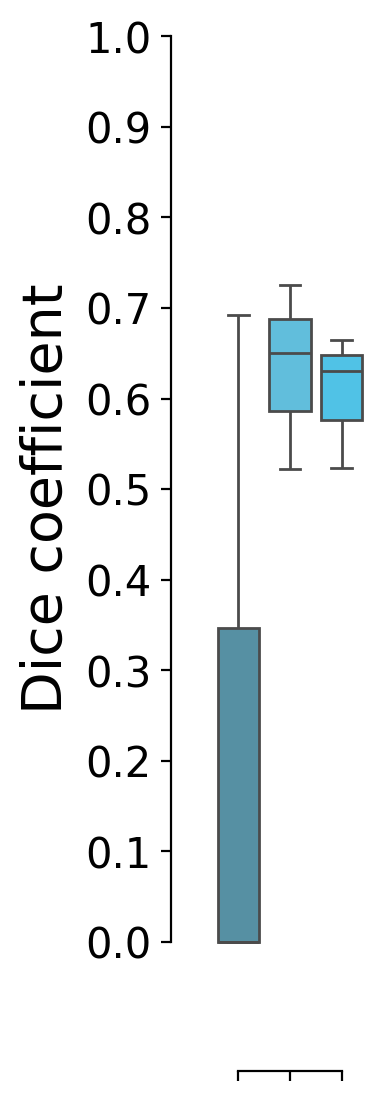

Cellpose


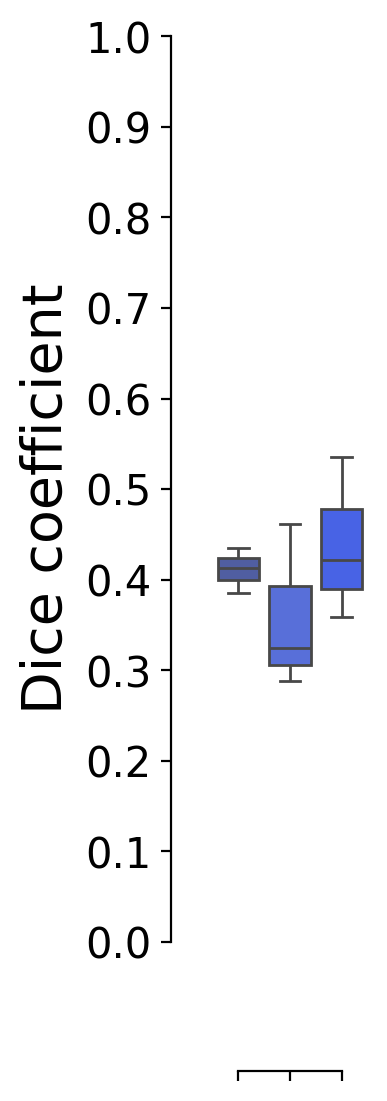

SegResNet


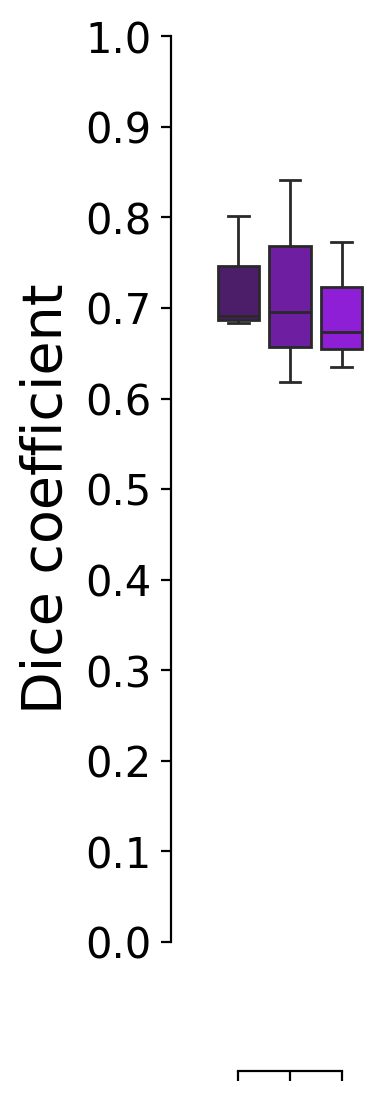

SwinUNetR


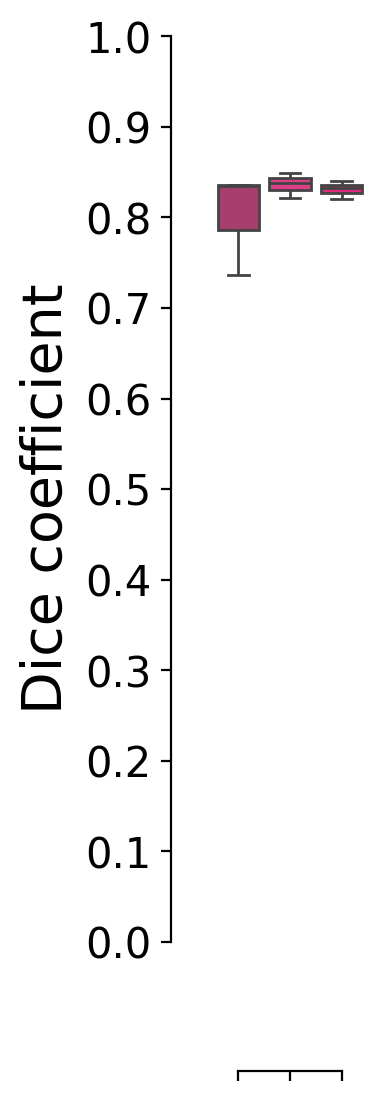

WNet3D


C:\Users\Cyril\AppData\Local\Temp\ipykernel_26660\3676559911.py:10: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(


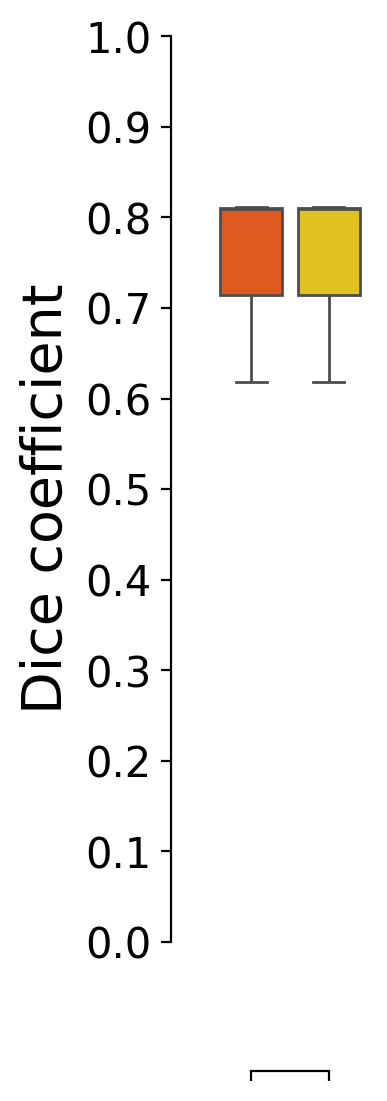

In [26]:
# Render each boxplot separately per model
models_dfs = [dices_df[dices_df["Model"] == model].copy() for model in model_names]
save_path = Path("label_efficiency")
save_path.mkdir(exist_ok=True)
for i, model in enumerate(model_names):
    print(model)
    # figsize_width = 1 if model != "WNet - Ours" else 0.33 # does not accept float values
    fig, ax = plt.subplots(figsize=(1, 6), dpi=DPI)
    df = models_dfs[i]
    sns.boxplot(
        data=df,
        x="Model_Split", 
        y="Dice", 
        hue="Split", 
        ax=ax, 
        palette=EXPANDED_COLORMAP[0+3*i:3+3*i],
    )
    ax.tick_params(axis = 'x',   rotation = 45)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(axis="both", which="major", labelsize=LEGEND_FONT_SIZE)
    ax.set_yticks(np.arange(0,1.1,0.1))
    ax.set_ylim([-0.02,1])
    sns.despine(
        left=False,
        right=True,
        bottom=False,
        top=True,
        trim=True,
        offset={"bottom": 40, "left": 15},
        ax=ax
    )
    ax.set_xticklabels("", fontsize=LABEL_FONT_SIZE)
    ax.set_xlabel("", fontsize=LABEL_FONT_SIZE)
    ax.set_ylabel("Dice coefficient", fontsize=LABEL_FONT_SIZE)
    ax.legend([],[], frameon=False)
    ax.patch.set_alpha(0)
    legend = ax.get_legend()
    if legend:
        legend.remove()
    # ax.set_title(model, fontsize=LABEL_FONT_SIZE)
    plt.show()
    if SAVE_PLOTS_AS_PNG:
        fig.savefig(f"{str(save_path)}/Label_efficiency_{model}.png", dpi=DPI, bbox_inches="tight")
    if SAVE_PLOTS_AS_SVG:
        fig.savefig(f"{str(save_path)}/Label_efficiency_{model}.svg", bbox_inches="tight")

### Zoom-in for rightmost models

C:\Users\Cyril\AppData\Local\Temp\ipykernel_26660\369744123.py:3: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.boxplot(data=dices_df.iloc[27:,:], x="Model", y="Dice", hue="Split", ax=ax, palette=EXPANDED_COLORMAP[9:], dodge=True)


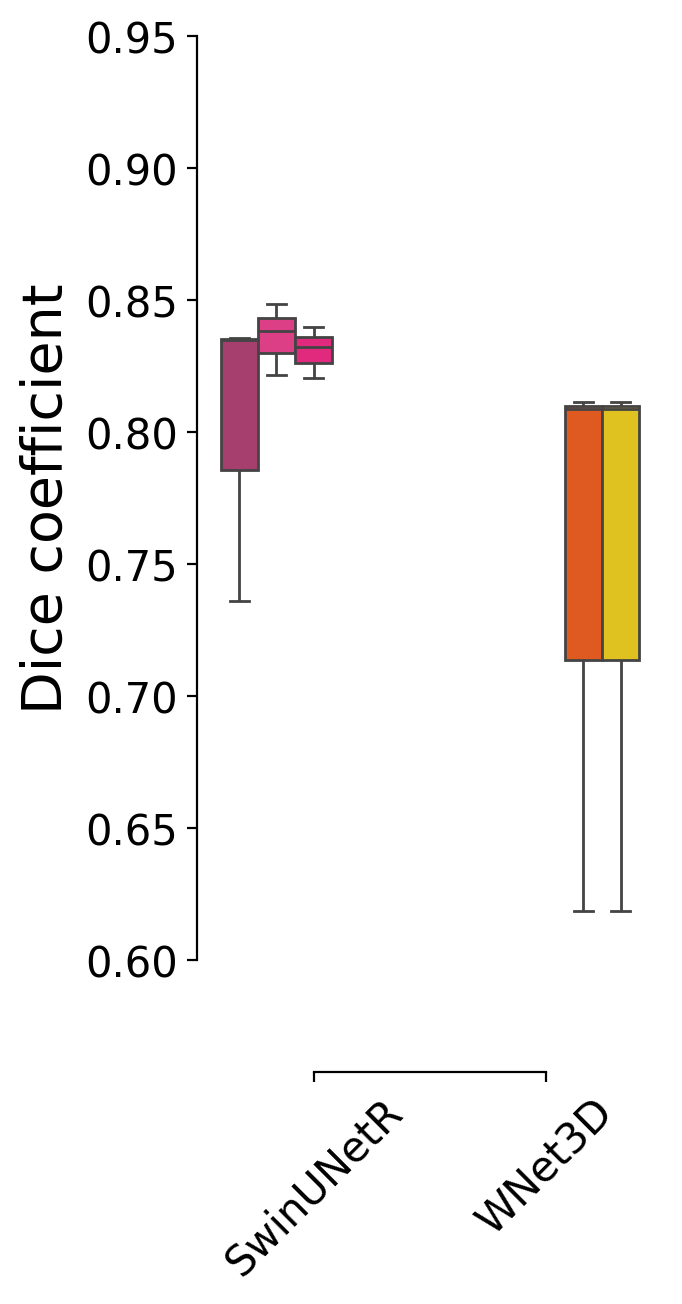

In [27]:
# same as above with Swin and WNet and y axis on the right
fig, ax = plt.subplots(figsize=(3, 6), dpi=DPI)
sns.boxplot(data=dices_df.iloc[27:,:], x="Model", y="Dice", hue="Split", ax=ax, palette=EXPANDED_COLORMAP[9:], dodge=True)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(axis="both", which="major", labelsize=LEGEND_FONT_SIZE)
ax.tick_params(axis = 'x',   rotation = 45,)
# ax.set_ylim([0.8,0.85])
# ax.set_yticks(np.arange(0.8,0.86,0.01))
ax.set_ylim([0.6,0.95])
ax.set_yticks(np.arange(0.6,0.96,0.05))
ax.set_xlabel("", fontsize=LABEL_FONT_SIZE)
ax.set_ylabel("Dice coefficient", fontsize=LABEL_FONT_SIZE)
ax.legend_.remove()
sns.despine(
    left=False,
    right=True,
    bottom=False,
    top=True,
    trim=True,
    offset={"bottom": 40, "right": 15},
)
# legend = ax.legend(fontsize=LEGEND_FONT_SIZE, bbox_to_anchor=BBOX_TO_ANCHOR, loc=LOC)
# legend.get_frame().set_alpha(0)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

if SAVE_PLOTS_AS_PNG:
    fig.savefig("Label_efficiency_SWIN_WNET_zoom.png", dpi=DPI, bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    fig.savefig("Label_efficiency_SWIN_WNET_zoom.svg", bbox_inches="tight")